In [ ]:
# Import relevant packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Import all the functions
from config import *
from training_pipeline import *
from plotting.plot_rates import *
from shap_functions import *

# Notebook Intent
This notebook is intended to provide an exploration of the repository functions and how to use them, as well as some exploratory analysis.
Among other topics, we cover:
- Plot the rates across deciles
- Investigate correlation between output and firm size
- Regression for ranking
- Shap values at model and TIN level
- Alignment between XGB and OCT predictions

### 1. Data Loading
If full_data_armenia_pre_correction_complex_only.csv is not available, run merge_data.py

In [3]:
# load the output of merge_data.py
df = pd.read_csv(f'{path_to_generated}/full_data_armenia_pre_correction_complex_only.csv')

/var/folders/8c/j4vpcb4d6td912dhs__qrm500000gn/T/ipykernel_92536/796096040.py:2: DtypeWarning: Columns (277) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{path_to_generated}/full_data_armenia_pre_correction_complex_only.csv')


### 2. Train Models

In [5]:
# Set save_path=None not to overwrite the already saved models, this is just for display
save_path=None
for target in ['AUDIT_ANY', 'FRAUD_ANY', 'CORRECT_PROFIT', 'FRAUD_OR_CORRECT']:
    print(f"Target: {target}")
    model_names, models = run_production_training(
        df, target=target, training_years=[2022], subset='all',
        random_seed=1, save_path=save_path, interpretable=False
    )


Target: AUDIT_ANY
Target: FRAUD_ANY
Target: CORRECT_PROFIT
Target: FRAUD_OR_CORRECT


### 3. Display Model Deciles
FRAUD_OR_CORRECT is the model that predicts either Fraud or Correction

In [6]:
# Load the best models for the target of interest
target = 'FRAUD_OR_CORRECT'
data_type = 'data_vat' if target == 'FRAUD_VAT' else 'data_all'
audit_type = 'AUDIT_VAT_RELATED' if target == 'FRAUD_VAT' else 'AUDIT_ANY' # AUDIT_ANY in this case are the complex audits

with open(f'models/{target}/training_years_[2022]/{data_type}/lnr_xgb.pkl', 'rb') as f:
    tmp_dict_model = pickle.load(f)
    fraud_lnr_xgb = tmp_dict_model['model']

with open(f'models/{target}/training_years_[2022]/{data_type}/lnr_rf.pkl', 'rb') as f:
    tmp_dict_model = pickle.load(f)
    fraud_lnr_rf = tmp_dict_model['model']

with open(f'models/{audit_type}/training_years_[2022]/{data_type}/lnr_xgb.pkl', 'rb') as f:
    tmp_dict_model = pickle.load(f)
    audit_lnr_xgb = tmp_dict_model['model']

# the audit model data has all the rows, audited or not
test_X_all = pd.read_csv(f"models/{audit_type}/training_years_[2022]/{data_type}/test_X.csv", index_col=0)
train_X_all = pd.read_csv(f"models/{audit_type}/training_years_[2022]/{data_type}/train_X.csv", index_col=0)

In [7]:
test_X = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/test_X.csv", index_col=0)
test_y = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/test_y.csv", index_col=0)
pred_y = fraud_lnr_xgb.predict(test_X[fraud_lnr_xgb.feature_names_in_])
metrics = evaluate_models(
    ['xgb'],
    [fraud_lnr_xgb],
    test_X,
    test_y[target].to_list(),
    interpretable=False
)
metrics

{'xgb': {'accuracy': 0.6603139013452914,
  'auc': 0.7306265510271958,
  'tn': 454,
  'fp': 51,
  'fn': 252,
  'tp': 135}}

In [8]:
# Create dataset with the predictions and the corresponding deciles
preds = prepare_predictions(
        df, test_X_all, audit_lnr_xgb, fraud_lnr_xgb, fraud_lnr_rf, audit_type, target
)

fraud_stats = calculate_stats(preds, 'fraud')
audit_stats = calculate_stats(preds, 'audited')

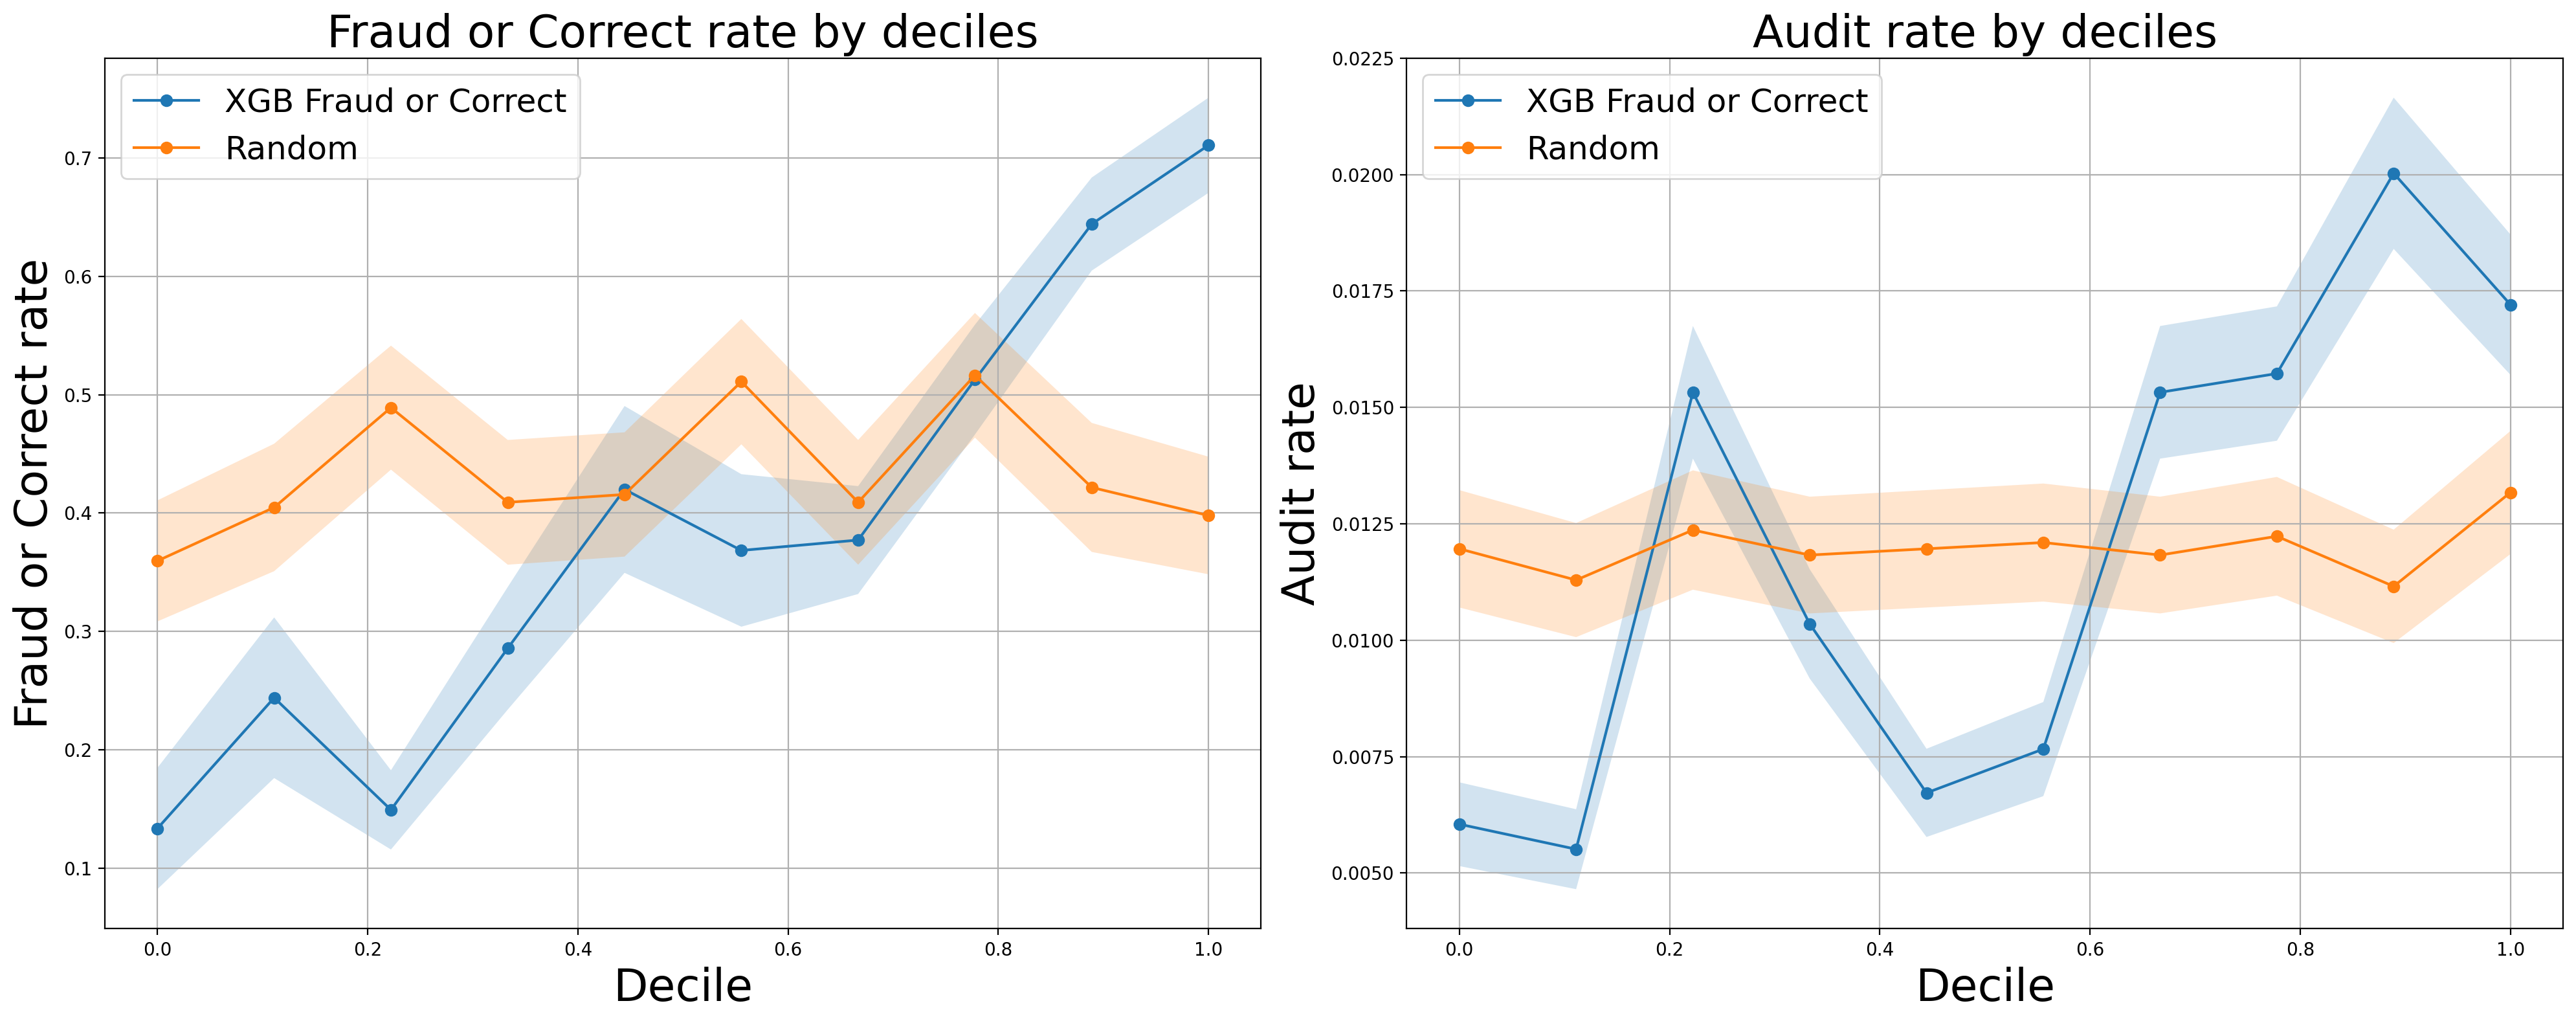

In [9]:
plot_rates(
    {key: val for key, val in fraud_stats.items() if key in ['decile_fraud_xgb', 'decile_rand']},
    {key: val for key, val in audit_stats.items() if key in ['decile_fraud_xgb', 'decile_rand']}, target, error_bars=False
)

### Investigate Correlation

In [10]:
# remove too large outliers because they skew the correlation computation
# tmp_df = df.loc[(df['has_financial']==1)&(df['DUE_PAYMENT_SUM']> 0)&(df['DUE_PAYMENT_SUM'] < 1e8), :] # fraud vat
tmp_df = df.loc[(df['DUE_PAYMENT_SUM']> 0)&(df['DUE_PAYMENT_SUM'] < 1e8), :] # fraud any
tmp_df.shape

(433, 392)

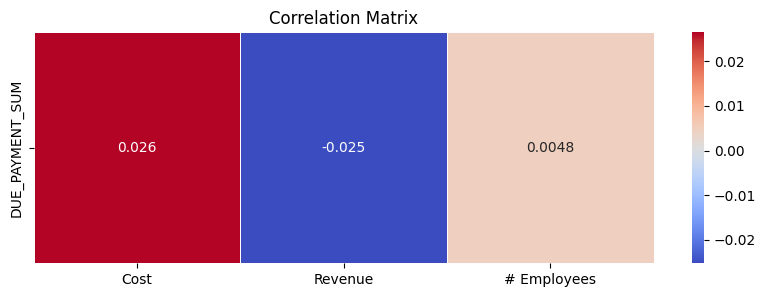

In [11]:
correlation_matrix = tmp_df[[
    'DUE_PAYMENT_SUM',
    'A62',
    'A41',
    'AVG_N_EMPLOYEES',
    ]].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 3))
sns.heatmap(correlation_matrix.loc[['DUE_PAYMENT_SUM']].drop('DUE_PAYMENT_SUM', axis=1).rename(columns={"A62": "Cost", "A41": "Revenue", "AVG_N_EMPLOYEES": "# Employees"}), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

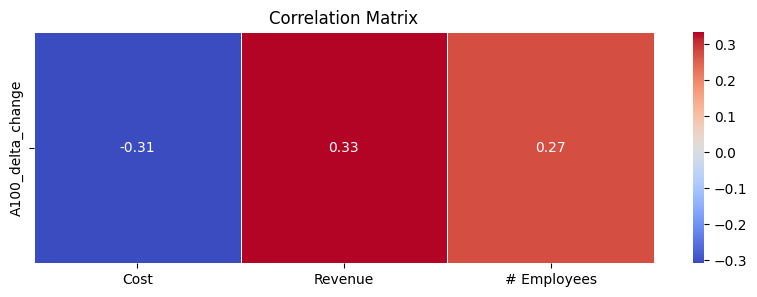

In [12]:
# Look at correction size correlation
tmp_df = df.loc[
    (
        (df['CORRECT_PROFIT']==1) &
        (df['A100_delta_change'] < 5e8) &
        (df['TAX_YEAR'].isin([2022, 2023]))
    )
]
correlation_matrix = tmp_df[[
    'A100_delta_change',
    'A62',
    'A41',
    'AVG_N_EMPLOYEES',
    ]].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 3))
sns.heatmap(correlation_matrix.loc[['A100_delta_change']].drop('A100_delta_change', axis=1).rename(columns={"A62": "Cost", "A41": "Revenue", "AVG_N_EMPLOYEES": "# Employees"}), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

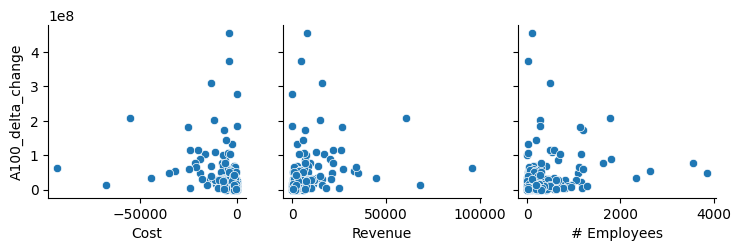

In [13]:
# Pairplot using seaborn to plot pairwise relationships
sns.pairplot(tmp_df.rename(columns={'A62': 'Cost', 'A41': 'Revenue', 'AVG_N_EMPLOYEES': '# Employees'}), y_vars=['A100_delta_change'], x_vars=['Cost', 'Revenue', '# Employees'])
plt.show()

### Try to predict correction size

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

def get_metrics(test_y, y_pred, epsilon=1e-10):
    r2 = r2_score(test_y, y_pred)
    mae = mean_absolute_error(test_y, y_pred)
    mape = np.mean(np.abs((test_y - y_pred) / (test_y + epsilon))) * 100
    dict_results = {'r2': np.round(r2, 4), 'mae': np.round(mae, 4), 'mape': np.round(mape, 4)}
    return dict_results

In [15]:
deciles = [7, 8, 9]
dict_data = dict()
for tmp_X, data in zip(
    [train_X_all, test_X_all], ['train', 'test']
):
    if 'fraud_or_correct_decile' in tmp_X.columns:
        tmp_X = tmp_X.drop('fraud_or_correct_decile', axis=1)

    # Prepare a dataset with prediction information
    preds = prepare_predictions(
            df, tmp_X, audit_lnr_xgb, fraud_lnr_xgb, fraud_lnr_rf, audit_type, target
    )
    preds.index = tmp_X.index

    # Get the deciles from the model of interest
    tmp_X['fraud_or_correct_decile'] = preds['decile_fraud_rf'].to_list()

    # Subset to the samples that have been corrected and deciles of interest
    X = tmp_X.loc[
        (
            (df.loc[tmp_X.index, 'CORRECT_PROFIT']) &
            (tmp_X['fraud_or_correct_decile'].isin(deciles)) &
            (tmp_X['A62'] > -50000) & # Remove Cost outliers
            (tmp_X['A41'] < 50000) & # Remove Revenue outliers
            (tmp_X['AVG_N_EMPLOYEES'] < 2000)  # Remove # of Employees
        )
    ].drop('fraud_or_correct_decile', axis=1).fillna(0)

    # Get the correction size
    y = df.loc[X.index, 'A100_delta_change']

    # Remove large outliers
    X = X[y < 1e8]
    y = y[y < 1e8]
    
    dict_data[f'{data}_X'] = X
    dict_data[f'{data}_y'] = y
    dict_data[f'{data}_preds'] = preds

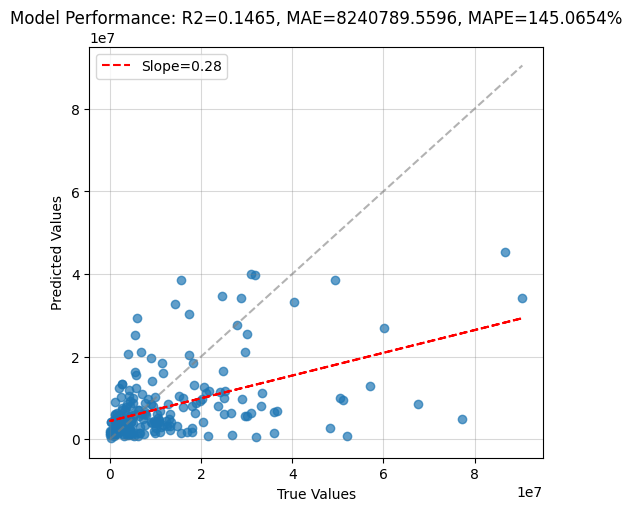

In [16]:
from sklearn.linear_model import LinearRegression
import xgboost

train_X, train_y = dict_data['train_X'], dict_data['train_y']
test_X, test_y = dict_data['test_X'], dict_data['test_y']
pred_cols = ['A62', 'A41', 'AVG_N_EMPLOYEES',]

# # Training the Linear Regression model
# model = LinearRegression()
model = xgboost.XGBRegressor()
model.fit(train_X, train_y.apply(lambda x: np.log(x)))
# model.fit(train_X[pred_cols], train_y)

# Making predictions
y_pred = model.predict(test_X)
y_pred = np.exp(y_pred)
y_pred = y_pred.clip(train_y.min(), train_y.max())

# Evaluating the model using get_metrics function
metrics = get_metrics(test_y, y_pred)

# Plotting predicted vs true values
_ = plot_prediction(
    test_y, y_pred, title=f"Model Performance: R2={metrics['r2']}, MAE={metrics['mae']}, MAPE={metrics['mape']}%", 
    xlabel='True Values', ylabel="Predicted Values"
)

From the plot above, we learn that the regression model is better than random guessing, and we can use it for auditing

### Ranking

Plot distribution of corrections by year. It seems that 14 adn 16 are good thresholds for low and medium corrections

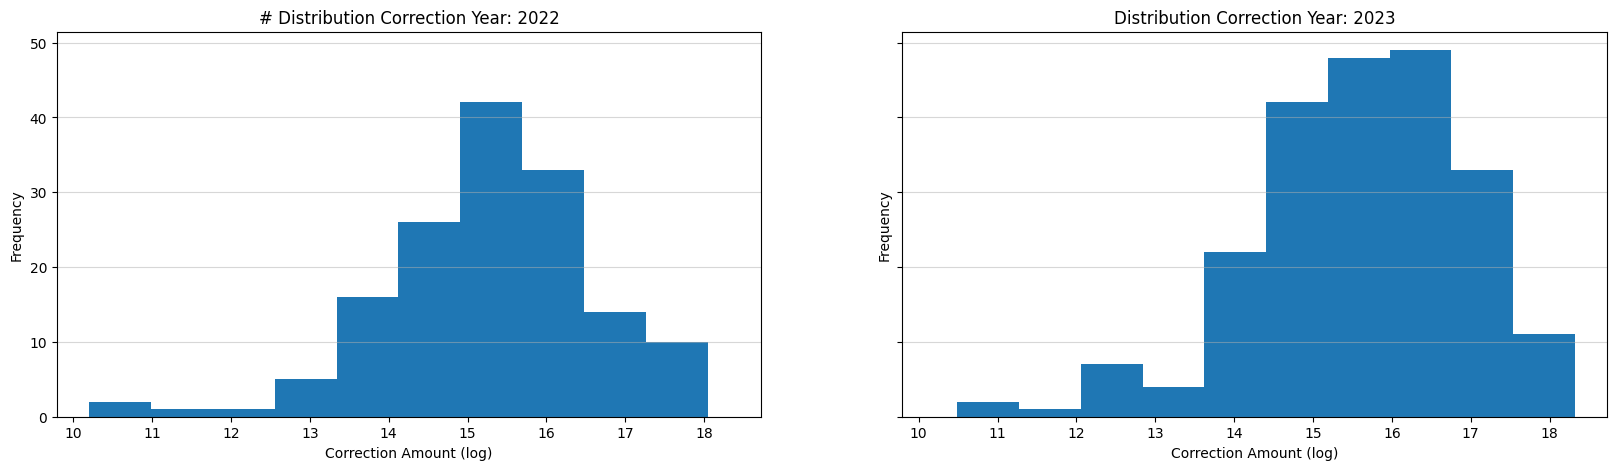

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5), sharey='all', sharex='all')
axs[0].hist(train_y.apply(lambda x: np.log(x)))
axs[0].set_title(f'# Distribution Correction Year: 2022')
axs[1].hist(test_y.apply(lambda x: np.log(x)))
axs[1].set_title('Distribution Correction Year: 2023')
for ax in axs:
    ax.grid(axis='y', alpha=0.5)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Correction Amount (log)')

In [18]:
def bin_values(x, low_thresh, mid_thresh):
    assert x < 100, 'Values need to be log scaled'

    if (x < low_thresh):
        return 0
    elif (x >= low_thresh) & (x < mid_thresh):
        return 1
    else:
        return 2

In [19]:
# train classification model
model_clf = xgboost.XGBClassifier(random_state=123)
(low_thresh, mid_thresh) = (14, 16)
train_y_clf = train_y.apply(lambda x: bin_values(np.log(x), low_thresh, mid_thresh))
test_y_clf = test_y.apply(lambda x: bin_values(np.log(x), low_thresh, mid_thresh))
model_clf.fit(train_X, train_y_clf)

dict_metrics_clf = classification_report(test_y_clf, model_clf.predict(test_X), output_dict=True)
dict_classification = dict_metrics_clf
dict_classification['model'] = model_clf
print("Classification model: \n", classification_report(test_y_clf, model_clf.predict(test_X)))

Classification model: 
               precision    recall  f1-score   support

           0       0.38      0.36      0.37        25
           1       0.55      0.75      0.64       101
           2       0.68      0.42      0.52        93

    accuracy                           0.57       219
   macro avg       0.54      0.51      0.51       219
weighted avg       0.59      0.57      0.56       219



In [20]:
test_X = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/test_X.csv", index_col=0)
preds = dict_data['test_preds'].loc[test_X.index]

pred_proba_clf = model_clf.predict_proba(test_X)
pred_clf = model_clf.predict(test_X)

preds['change_amount'] = df.loc[test_X.index, 'A100_delta_change'].to_list()
preds['prob_low_change'] = pred_proba_clf[:, 0]
preds['prob_medium_change'] = pred_proba_clf[:, 1]
preds['prob_high_change'] = pred_proba_clf[:, 2]
preds['pred_change_class'] = pred_clf
preds['predicted_change'] = model.predict(test_X)

preds

,audit_xgb,fraud_xgb,fraud_rf,audited,fraud,TIN,TAX_YEAR,proba_rand,decile_xgb_audit,decile_fraud_rf,decile_fraud_xgb,decile_rand,change_amount,prob_low_change,prob_medium_change,prob_high_change,pred_change_class,predicted_change
335,0.084124,0.018465,0.13,True,False,5884563,2023,0.865621,9,4,3,8,0.0,0.046523,0.951176,0.002301,1,14.712219
501,0.001182,0.005290,0.05,True,False,8497158,2023,0.729504,4,1,2,7,0.0,0.983831,0.014677,0.001492,0,13.886305
656,0.000734,0.013101,0.02,True,False,11818829,2023,0.624564,2,0,3,6,0.0,0.917022,0.073980,0.008999,0,14.127846
2217,0.220950,0.744838,0.50,True,True,41812990,2023,0.282000,9,9,9,2,826238.0,0.002695,0.953215,0.044090,1,15.361141
2347,0.001098,0.255402,0.32,True,True,43942604,2023,0.013128,4,7,7,0,298514.0,0.952267,0.044040,0.003693,0,12.574643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224129,0.956463,0.011932,0.14,True,False,4265791710,2023,0.097239,9,4,3,0,24410365.0,0.000661,0.023206,0.976133,2,17.286638
224386,0.617207,0.078110,0.24,True,False,4270405135,2023,0.937137,9,6,6,9,12792248.0,0.000287,0.003109,0.996604,2,17.328482
224512,0.073121,0.255131,0.39,True,True,4272563660,2023,0.939606,9,8,7,9,2595532.0,0.003178,0.946649,0.050173,1,15.832627
224667,0.004177,0.034631,0.24,True,False,4275654942,2023,0.783033,7,6,4,7,0.0,0.283961,0.574466,0.141573,1,14.104548


In [21]:
# number of companies to audit
n = 50

# proportion to draw from the last three deciles
props = {
    7: 0.10,
    8: 0.20,
    9: 0.70,
}

assert np.round(sum(props.values()), 2) == 1, "Proportions need to sum to 1"

In [22]:
deciles = list(props.keys())

for sort_method in ['Predict Change Regression', 'Predict Change Classification']:
    print(sort_method)
    total_random = 0
    total_rf = 0

    for decile in deciles:
        tmp_n = int(n * props[decile])
        tmp_preds_random = preds.loc[preds['decile_rand'] == decile]
        tmp_preds_rf = preds.loc[preds['decile_fraud_rf'] == decile]
        
        if sort_method == 'Predict Change Regression':
            # sort by predicted change
            tmp_preds_rf = tmp_preds_rf.sort_values('predicted_change', ascending=False)
        else:
            # sort by predicted class
            tmp_preds_rf = tmp_preds_rf.sort_values(['pred_change_class', 'prob_high_change'], ascending=False)

        random_amount = tmp_preds_random.sample(tmp_n, random_state=1)['change_amount'].sum()
        rf_amount = tmp_preds_rf.head(tmp_n)['change_amount'].sum()

        total_random += random_amount
        total_rf += rf_amount
        print(f"\tDecile: {decile+1}")
        print(f"\tChange Amount Random/RF: {random_amount}/{rf_amount}")
        print(f"\tRF-driven Changes are {np.round(rf_amount/random_amount, 2)}x times larger than random \n")
    print(f"\tTotal Change Amount Random/RF: {total_random}/{total_rf}")
    print(f"\tRF-driven Changes are {np.round(total_rf/total_random, 2)}x times larger than random", end='\n\n')

Predict Change Regression
	Decile: 8
	Change Amount Random/RF: 16374951.0/10928980.0
	RF-driven Changes are 0.67x times larger than random 

	Decile: 9
	Change Amount Random/RF: 140475740.0/74538311.0
	RF-driven Changes are 0.53x times larger than random 

	Decile: 10
	Change Amount Random/RF: 208222330.0/1485247259.0
	RF-driven Changes are 7.13x times larger than random 

	Total Change Amount Random/RF: 365073021.0/1570714550.0
	RF-driven Changes are 4.3x times larger than random

Predict Change Classification
	Decile: 8
	Change Amount Random/RF: 16374951.0/2287538939.0
	RF-driven Changes are 139.7x times larger than random 

	Decile: 9
	Change Amount Random/RF: 140475740.0/147929088.0
	RF-driven Changes are 1.05x times larger than random 

	Decile: 10
	Change Amount Random/RF: 208222330.0/1298186591.0
	RF-driven Changes are 6.23x times larger than random 

	Total Change Amount Random/RF: 365073021.0/3733654618.0
	RF-driven Changes are 10.23x times larger than random



### Explain model behavior with SHAP

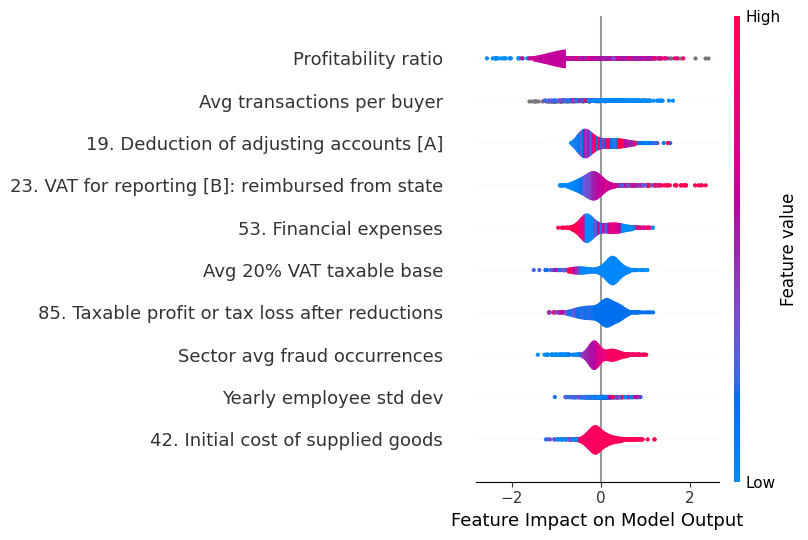

In [23]:
train_X = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/train_X.csv", index_col=0)
explainer, is_rf = get_shap_explainer(fraud_lnr_xgb)

with open(f'models/{target}/training_years_[2022]/{data_type}/global_shap_values.pkl', 'rb') as f:
    dict_values = pickle.load(f)
shap_values = dict_values['shap_values']
model_features = dict_values['model_features']

top_features = plot_shap_summary(
    train_X[model_features], shap_values, map_features=True, n_features=10, save_path=None
)

In [24]:
with open('data_samples/generated/tin_tax_year_results.pkl', 'rb') as f:
    dict_tin_tax_year = pickle.load(f)

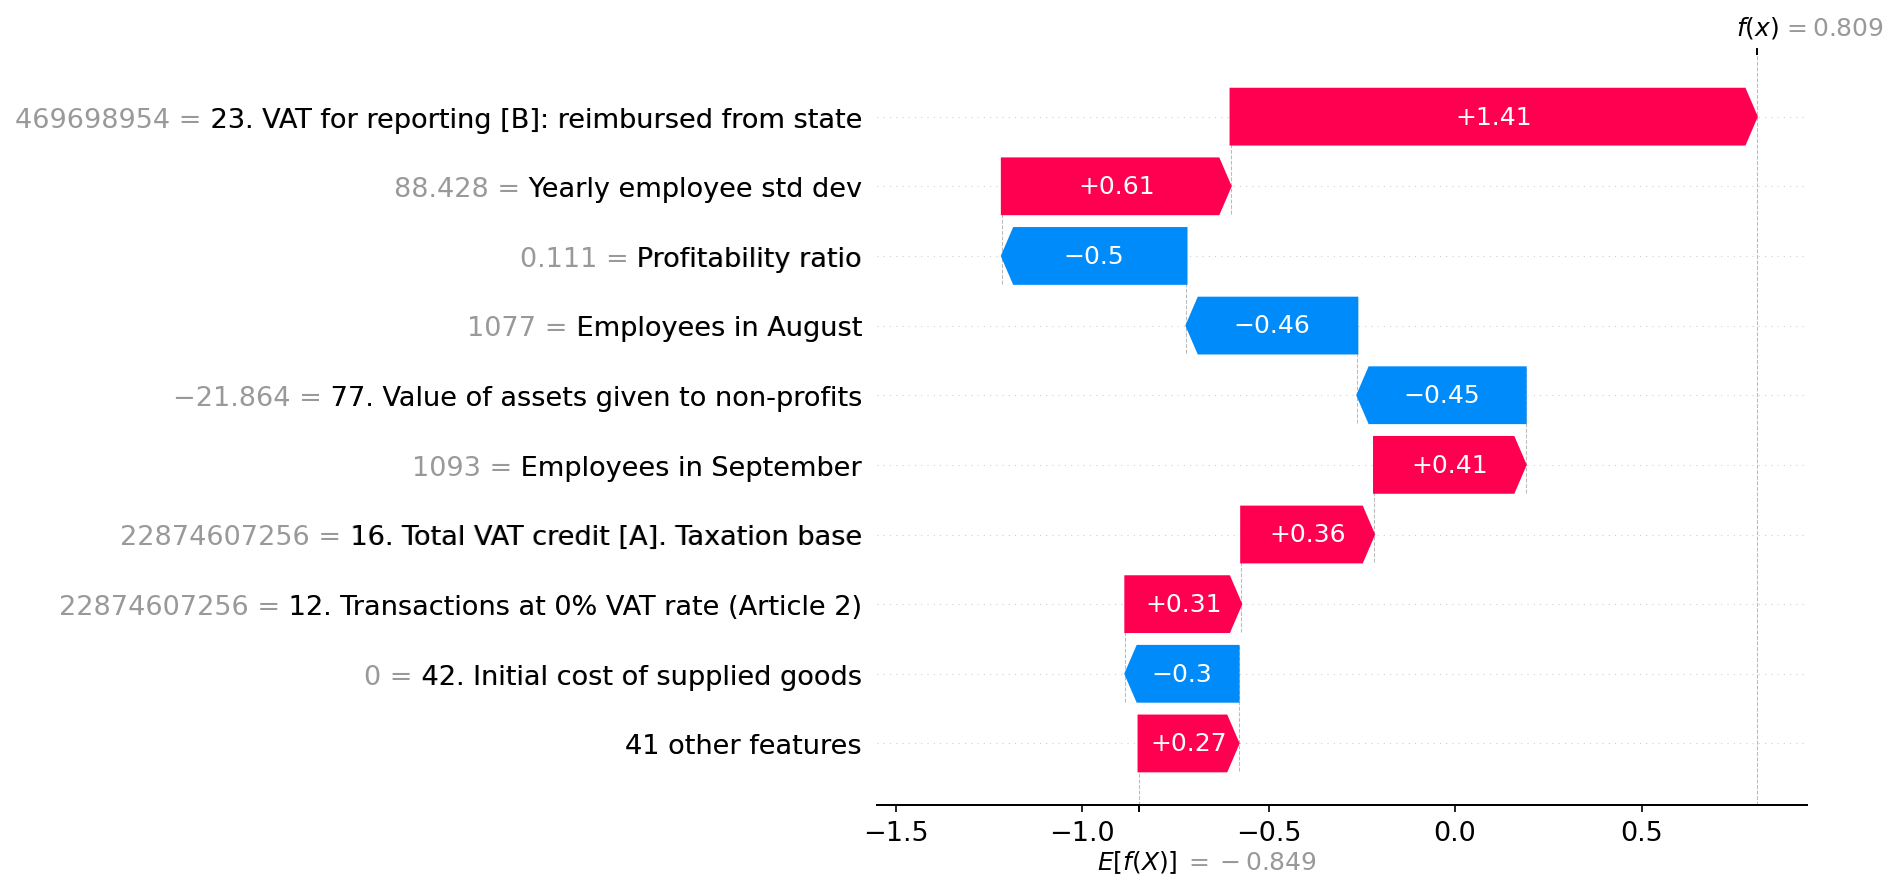

In [25]:
from shap_functions import plot_shapley_per_sample
TIN = 927464691
TAX_YEAR = 2023
n_features = 10

sample = dict_tin_tax_year[TIN][TAX_YEAR]['sample']
sample_shap_values = dict_tin_tax_year[TIN][TAX_YEAR]['sample_shap_values']
expected_value = dict_tin_tax_year[TIN][TAX_YEAR]['expected_value']
top_features_sample = plot_shapley_per_sample(
    sample_shap_values, expected_value, sample, map_features=True, feature_names=sample.index, n_features=n_features, save_path=None
)

# Global model interpretation on full population

This is basically a summary of how all the TIN level interpretations will look like

/var/folders/8c/j4vpcb4d6td912dhs__qrm500000gn/T/ipykernel_92536/1290378194.py:39: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


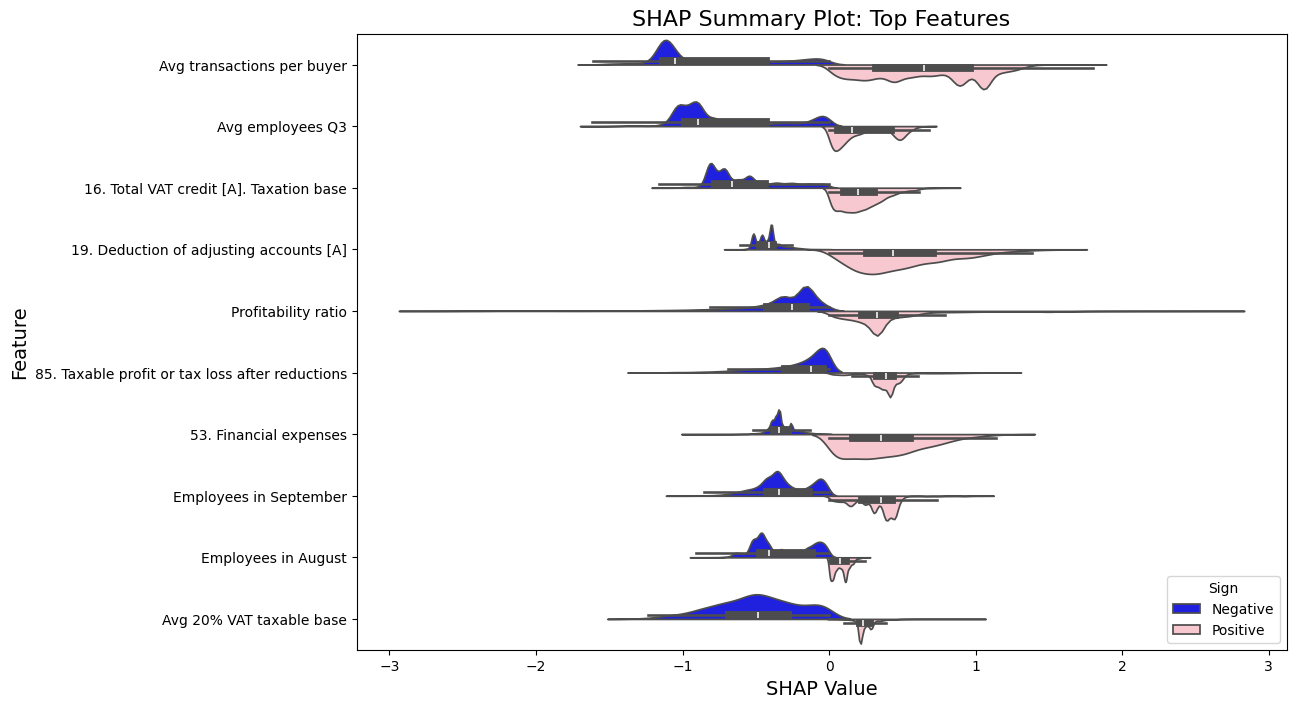

In [27]:
# Initialize storage for SHAP values and feature names
shap_values_list = []
feature_names = None

# Extract SHAP values and ensure consistent feature names
for tin, tax_year_data in dict_tin_tax_year.items():
    for tax_year, data in tax_year_data.items():
        shap_values = data['sample_shap_values']
        sample = data['sample']
        
        # Store SHAP values
        shap_values_list.append(shap_values)
        
        # Use feature names from the first sample (assuming consistency)
        if feature_names is None:
            feature_names = sample.index

# Convert SHAP values to a NumPy matrix
shap_values_matrix = np.vstack(shap_values_list)

# Create a DataFrame for easier aggregation
shap_values_df = pd.DataFrame(shap_values_matrix, columns=[mapping_short[f] for f in feature_names])

# Select top features by mean absolute SHAP value
mean_absolute_shap = shap_values_df.abs().mean().sort_values(ascending=False)
top_features = mean_absolute_shap.index[:10]  # Select top 10 features

# Subset the DataFrame to only include top features
shap_values_top = shap_values_df[top_features]

# Melt the DataFrame for seaborn's violin plot
shap_values_melted = shap_values_top.melt(var_name="Feature", value_name="SHAP Value")

# Add a dummy column to use for coloring
shap_values_melted['Sign'] = np.where(shap_values_melted['SHAP Value'] > 0, 'Positive', 'Negative')

# Plot the violin plot with SHAP-style coloring
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=shap_values_melted,
    x="SHAP Value",
    y="Feature",
    scale="width",
    hue="Sign",  # Separate by sign for coloring
    palette={"Positive": "pink", "Negative": "blue"},  # SHAP-like colors
    split=True  # Overlay positive and negative violins
)
plt.title("SHAP Summary Plot: Top Features", fontsize=16)
plt.xlabel("SHAP Value", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.legend(title="Sign", loc="lower right")

# # Number of Features Exploration

In [ ]:
# Load the best models for the target of interest
target = 'FRAUD_OR_CORRECT'
data_type = 'data_vat' if target == 'FRAUD_VAT' else 'data_all'
audit_type = 'AUDIT_VAT_RELATED' if target == 'FRAUD_VAT' else 'AUDIT_ANY' # AUDIT_ANY in this case are the complex audits

train_X = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/train_X.csv", index_col=0)
train_y = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/train_y.csv", index_col=0)

test_X = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/test_X.csv", index_col=0)
test_y = pd.read_csv(f"models/{target}/training_years_[2022]/{data_type}/test_y.csv", index_col=0)

In [20]:
# Initialize and train the model
model = xgboost.XGBRegressor(
    random_state=123,
    eval_metric="rmse",
)

model.fit(train_X, train_y)

# Extract feature importances
feature_importances = top_features(model, train_X)

for n_features in [20, 30, 40, 50]:
    tmp_features = feature_importances.head(n_features)['names'].to_list()
    model_names, models = train_models(train_X[tmp_features], train_y, random_seed=1, interpretable=False)
    
    metrics = evaluate_models(
        model_names,
        models,
        test_X.reset_index(drop=True),
        test_y.reset_index(drop=True)[target],
        interpretable=False
    )

    print(
        f"# of Features: {n_features}; Target: {target}\n" +
        f"Accuracy XGB/RF: {metrics['xgb']['accuracy']:.4f}/{metrics['rf']['accuracy']:.4f}\n" +
        f"AUC XGB/RF: {metrics['xgb']['auc']:.4f}/{metrics['rf']['auc']:.4f}"
    )


/Users/lucamingardi/miniconda3/envs/armenia/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# of Features: 20; Target: FRAUD_OR_CORRECT
Accuracy XGB/RF: 0.6065/0.6065
AUC XGB/RF: 0.6811/0.7131


/Users/lucamingardi/miniconda3/envs/armenia/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# of Features: 30; Target: FRAUD_OR_CORRECT
Accuracy XGB/RF: 0.6278/0.5975
AUC XGB/RF: 0.6881/0.7110


/Users/lucamingardi/miniconda3/envs/armenia/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# of Features: 40; Target: FRAUD_OR_CORRECT
Accuracy XGB/RF: 0.6334/0.6256
AUC XGB/RF: 0.7159/0.7401


/Users/lucamingardi/miniconda3/envs/armenia/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# of Features: 50; Target: FRAUD_OR_CORRECT
Accuracy XGB/RF: 0.6603/0.6233
AUC XGB/RF: 0.7306/0.7617


# Alignment XGB and OCT Predictions

In [29]:
with open('data_samples/generated/tin_tax_year_results.pkl', 'rb') as f:
    dict_tin_tax_year = pickle.load(f)

In [44]:
import re
dict_values = {val: [] for val in ['xgb', 'oct']}
for tin, data_tin in dict_tin_tax_year.items():
    for tax_year, data_tin_tax_year in data_tin.items():

        sample_tree_explanation = data_tin_tax_year['sample_tree_explanation']
        match = re.search(r'P\(true\)\s*=\s*([0-9]+(\.[0-9]+)?)%', sample_tree_explanation)
        assert match, "Pattern doesn't match"
        tree_prob = match.group(1)
        tree_prob = float(tree_prob) / 100

        xgb_prob = data_tin_tax_year['predicted_prob']
        for prob, key in zip([xgb_prob, tree_prob], ['xgb', 'oct']):
            dict_values[key].append(prob)

Text(0, 0.5, 'OCT')

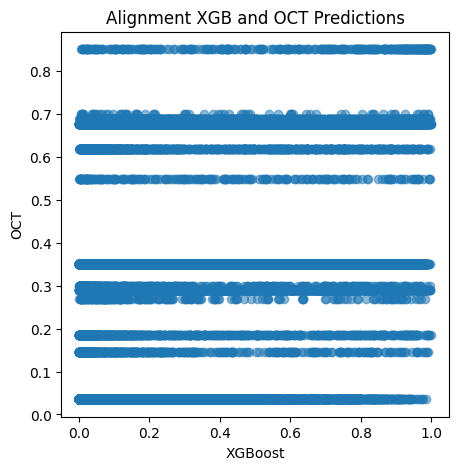

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)
axs.scatter(dict_values['xgb'], dict_values['oct'], alpha=0.5)
axs.set_title('Alignment XGB and OCT Predictions')
axs.set_xlabel('XGBoost')
axs.set_ylabel('OCT')

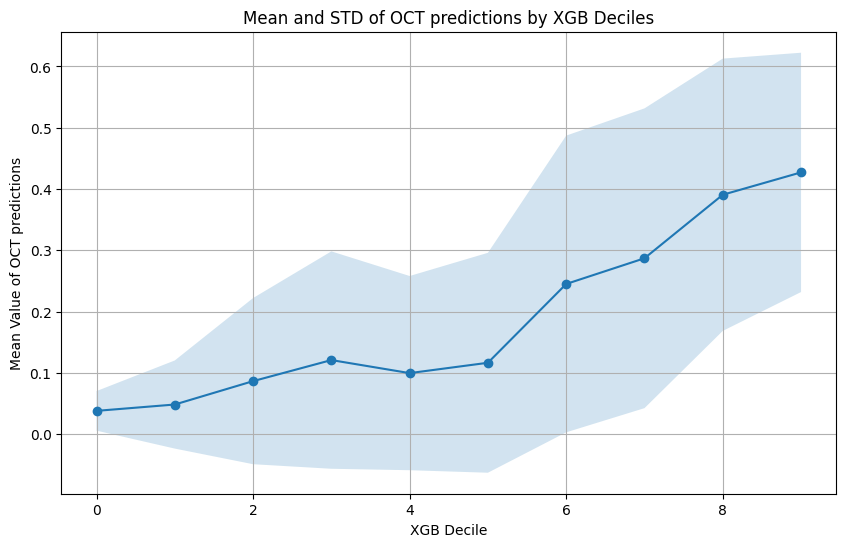

In [67]:
# Create a DataFrame for easier handling
data = pd.DataFrame({
    'xgb_preds': dict_values['xgb'],
    'oct_preds': dict_values['oct']
})

# Create decile bins for xgb_preds
data['decile'] = pd.qcut(data['xgb_preds'], q=10, labels=False)

# Calculate mean and std for each decile
grouped = data.groupby('decile')['oct_preds'].agg(['mean', 'std']).reset_index()

# Plot
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(grouped['decile'], grouped['mean'], label='Mean Value', marker='o')
plt.fill_between(grouped['decile'], 
                 grouped['mean'] - grouped['std'], 
                 grouped['mean'] + grouped['std'], 
                 alpha=0.2, label='Mean ± STD')
plt.xlabel('XGB Decile')
plt.ylabel('Mean Value of OCT predictions')
plt.title('Mean and STD of OCT predictions by XGB Deciles')
plt.grid(True)
plt.show()

In [52]:
data.groupby('decile')['xgb_preds'].agg(['mean', 'std']).reset_index()

,decile,mean,std
0,0,0.001036,0.000215
1,1,0.001848,0.000449
2,2,0.005467,0.001586
3,3,0.015520,0.003935
4,4,0.029250,0.004409
5,5,0.046398,0.005214
6,6,0.092650,0.024535
7,7,0.218302,0.048303
8,8,0.468342,0.096261
9,9,0.815937,0.096434


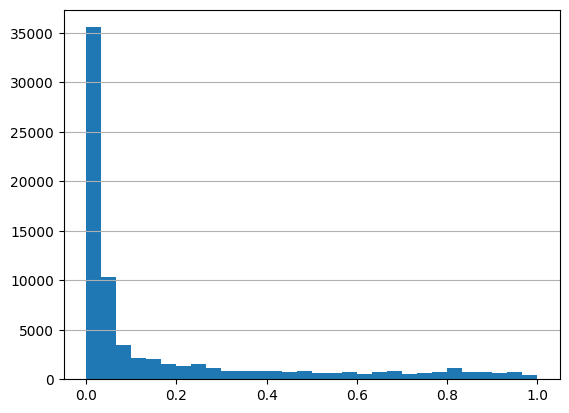

In [75]:
plt.hist(data['xgb_preds'], bins=30)
plt.grid(axis='y')
plt.show()

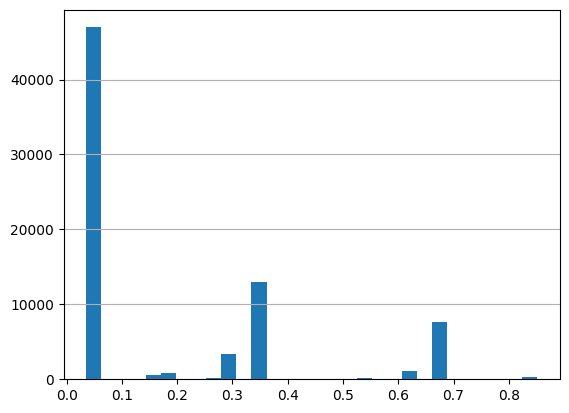

In [76]:
plt.hist(data['oct_preds'], bins=30)
plt.grid(axis='y')
plt.show()

/var/folders/8c/j4vpcb4d6td912dhs__qrm500000gn/T/ipykernel_92536/1522720356.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_buckets = data.groupby('bucket')['oct_preds'].agg(['mean', 'std', 'size']).reset_index()


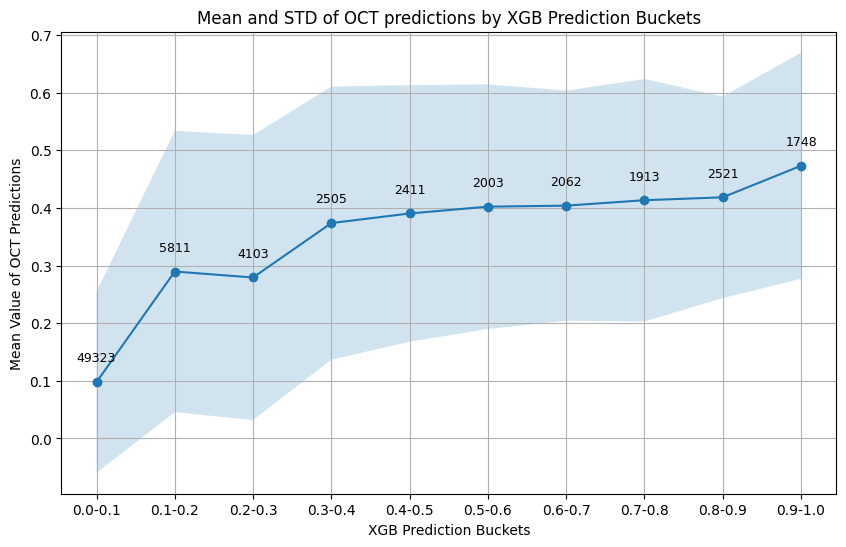

In [58]:
# Create custom bins for xgb_preds (0-0.1, 0.1-0.2, ..., 0.9-1.0)
bins = np.arange(0, 1.1, 0.1)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

data['bucket'] = pd.cut(data['xgb_preds'], bins=bins, labels=labels, include_lowest=True)

# Calculate mean, std, and size for each bucket
grouped_buckets = data.groupby('bucket')['oct_preds'].agg(['mean', 'std', 'size']).reset_index()

# Plot with bucket size annotations
plt.figure(figsize=(10, 6))
plt.plot(grouped_buckets['bucket'], grouped_buckets['mean'], label='Mean Value', marker='o')
plt.fill_between(grouped_buckets['bucket'], 
                 grouped_buckets['mean'] - grouped_buckets['std'], 
                 grouped_buckets['mean'] + grouped_buckets['std'], 
                 alpha=0.2, label='Mean ± STD')

# Add annotations for size
for i, (bucket, mean, size) in enumerate(zip(grouped_buckets['bucket'], grouped_buckets['mean'], grouped_buckets['size'])):
    plt.text(i, mean+0.03, f"{size}", ha='center', va='bottom', fontsize=9)

plt.xlabel('XGB Prediction Buckets')
plt.ylabel('Mean Value of OCT Predictions')
plt.title('Mean and STD of OCT predictions by XGB Prediction Buckets')
plt.grid(True)
plt.show()
